In [1]:
import pandas as pd
data = pd.read_csv("query_smiles_for_tc_train_anonymized.csv",sep='\t')

In [62]:
data.head()

,Unnamed: 0,Target,Molecule_ID,Activity,SMILES
0,0,B,0,1.80,CC(C)Oc1ccccc1N2CCN(Cc3cccc(c3)C(=O)N4CCCCC4)CC2
1,1,B,1,281.50,Oc1ccccc1OCCNCc2ccccc2
2,2,B,2,83.00,Oc1ccc2CCC3C(OCCN3CCc4cccs4)c2c1
3,3,B,3,27.80,CS(=O)(=O)Nc1cc(OCCNCc2cccs2)ccc1Cl
4,4,B,4,0.21,CCCN1CCOC2C1CCc3ccc(O)cc23


In [3]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

query_mol = Chem.MolFromSmiles('OC1(CCN(CCCC(=O)c2ccc(F)cc2)CC1)c3ccc(Cl)cc3')
mols = [Chem.MolFromSmiles(s) for s in data['SMILES']]

query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 4, nBits = 1024) # radius = 4
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits = 1024) for m in mols]

I don't know what radius should I set

In [4]:
TanimotoSimilarity = [DataStructs.FingerprintSimilarity(query_fp, fp) for fp in fps]

In [5]:
import numpy as np
import numbers
def convert_to_pki(affinities):
	    """Returns value in new_min to new_max scale
	
	    Parameters
	    ----------
	    affinities : np.float32 or pd.DataFrame
	        value to convert (in nanomolar)
	
	    Returns
	    ----------
	    new_val : np.float32
	        new value as pKi
	    """
	
	    if isinstance(affinities, pd.DataFrame):
	        affinities = -np.log10(affinities)
	        affinities += 9
	    elif isinstance(affinities, np.ndarray):
	        nonzeros = np.nonzero(affinities)
	        affinities[nonzeros] = -np.log10(affinities[nonzeros])
	        affinities[nonzeros] += 9
	    elif isinstance(affinities, numbers.Number):
	        affinities = 9 - np.log10(affinities)
	    else:
	        raise TypeError("only numpy ndarray and pandas dataframe types are supported. {} was found"
	                        .format(type(affinities)))
	    return affinities

In [6]:
activity = [convert_to_pki(a) for a in data['Activity']]
SA = zip(activity,TanimotoSimilarity)
SActivity = []
while True:
    SActivity.append(SA.__next__())

StopIteration: 

In [7]:
SActivity.sort()

In [13]:
activity_lt5 = []
similarity_lt5 = []
for i in range(len(SActivity)):
    if SActivity[i][0] < 5:
        activity_lt5.append(SActivity[i][0])
        similarity_lt5.append(SActivity[i][1])
    else:
        break
temp = SActivity[i:]
activity_gt5 = []
similarity_gt5 = []
for i in range(len(temp)):
    activity_gt5.append(temp[i][0])
    similarity_gt5.append(temp[i][1])

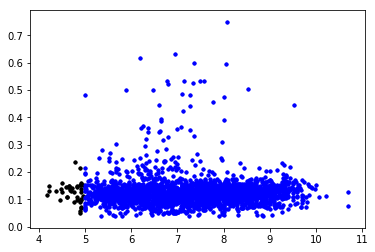

In [16]:
import matplotlib
import matplotlib.pyplot as plt

#plt.style.use('seaborn-whitegrid')
plt.scatter(activity_lt5, similarity_lt5, marker = '.', color = 'black')
plt.scatter(activity_gt5, similarity_gt5, marker = '.', color = 'blue')
plt.show()

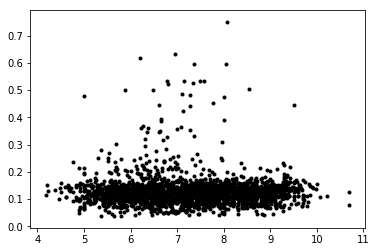

In [34]:
import matplotlib
import matplotlib.pyplot as plt

#plt.style.use('seaborn-whitegrid')
plt.scatter([convert_to_pki(a) for a in data['Activity']], TanimotoSimilarity, marker = '.', color = 'black')
#plt.scatter(data['Activity'], TanimotoSimilarity, maker = '.')
plt.show()

In [29]:
activity = np.array(data["Activity"])

In [56]:
activity = [convert_to_pki(a) for a in data['Activity']]

Random Forest:

In [58]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
rf_model.fit(fps, activity)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [59]:
rf_model.predict([query_fp])

array([ 7.18791325])

In [61]:
rf_model.feature_importances_

array([  1.17561237e-04,   1.28461289e-04,   2.82687877e-03, ...,
         1.35211082e-04,   4.73290001e-05,   8.34570619e-04])

SVM:

In [71]:
from sklearn import svm
svr = svm.SVR()
svr.fit(fps, activity)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [72]:
svr.predict([query_fp])

array([ 7.08951057])

In [73]:
test_mol = Chem.MolFromSmiles('COc1ccccc1N2CCN(CCCCNC(=O)\\C=C\\c3ccc4OCOc4c3)CC2')
test_fp = AllChem.GetMorganFingerprintAsBitVect(test_mol, 4, nBits = 1024) # radius = 4

In [74]:
svr.predict([test_fp])

array([ 8.83708898])

In [75]:
rf_model.predict([test_fp])

array([ 8.90000119])